# CAPSTONE INVESTIGACIÓN OPERATIVA

In [38]:
#encender .venv
!.\.venv\Scripts\activate.bat

El sistema no puede encontrar la ruta especificada.


### Instalación de dependencias en el .venv

In [1]:
# Instala y actualiza los paquetes necesarios
%pip install --upgrade pip
%pip install numpy==2.2 pandas scikit-learn matplotlib joblib gurobipy gurobi-machinelearning pandas-datareader xgboost shap optuna seaborn geopandas contextily

# Verifica la versión de scikit-learn y Python
import sklearn, sys
print("Python version:", sys.version)
print("scikit-learn version:", sklearn.__version__)

# Importa y verifica pandas_datareader
import importlib
import pandas_datareader as pdr
print("pandas_datareader OK:", importlib.metadata.version("pandas-datareader"))

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.Collecting numpy==2.2
   ---------------------------------------- 0.0/12.9 MB ? eta -:--:--
   - -------------------------------------- 0.5/12.9 MB 4.2 MB/s eta 0:00:03
   ---- ----------------------------------- 1.6/12.9 MB 4.0 MB/s eta 0:00:03
   -------- ------------------------------- 2.6/12.9 MB 4.4 MB/s eta 0:00:03
   ----------- ---------------------------- 3.7/12.9 MB 4.6 MB/s eta 0:00:02
   ------------- -------------------------- 4.5/12.9 MB 4.5 MB/s eta 0:00:02
   ------------------ --------------------- 6.0/12.9 MB 4.9 MB/s eta 0:00:02
   --------------------- ------------------ 6.8/12.9 MB 4.9 MB/s eta 0:00:02
   ------------------------ --------------- 7.9/12.9 MB 4.8 MB/s eta 0:00:02
   -------------------------- ------------- 8.7/12.9 MB 4.7 MB/s eta 0:00:01
   ------------------------------ --------- 9.7/12.9 MB 4.7 MB/s eta 0:00:01
   ----

### Importamos Librerias necesarias

In [2]:
# ============ Config & IO ============
import re
import time
#importamos numpy version 2.2
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)  # muestra todas las columnas

# ============ Scikit-learn ============
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
# ===== IMPORTS extra =====
from sklearn.base import clone           # por si no lo tenías
from xgboost import XGBRegressor         # pip install xgboost


# ============ Gurobi / MIP ============
import gurobipy as gp
from gurobipy import GRB
from gurobi_ml import add_predictor_constr

# ============ Datos externos (opcional) ============
from pandas_datareader.data import DataReader  # si usas FRED/CPI
from sklearn.base import clone

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

### Prepocesamiento de la base de datos "AmesHousing"

In [3]:
FILE = "ames_dum.csv"
df = pd.read_csv(FILE)
df.head()


,Lot_Frontage,Lot_Area,Land_Slope,Overall_Qual,Overall_Cond,Year_Built,Year_Remod_Add,Mas_Vnr_Area,Exter_Qual,Exter_Cond,Bsmt_Qual,Bsmt_Cond,Bsmt_Exposure,BsmtFin_Type_1,BsmtFin_SF_1,BsmtFin_Type_2,BsmtFin_SF_2,Bsmt_Unf_SF,Total_Bsmt_SF,Heating_QC,First_Flr_SF,Second_Flr_SF,Low_Qual_Fin_SF,Bsmt_Full_Bath,Bsmt_Half_Bath,Full_Bath,Half_Bath,Bedroom_AbvGr,Kitchen_AbvGr,Kitchen_Qual,TotRms_AbvGrd,Functional,Fireplaces,Garage_Finish,Garage_Cars,Garage_Area,Garage_Qual,Garage_Cond,Paved_Drive,Wood_Deck_SF,Open_Porch_SF,Enclosed_Porch,Three_season_porch,Screen_Porch,Pool_Area,Misc_Val,Mo_Sold,Year_Sold,Sale_Price,Longitude,Latitude,Fecha_Venta,CPI,Sale_Price_Log,MS_SubClass_One_Story_1945_and_Older,MS_SubClass_One_Story_with_Finished_Attic_All_Ages,MS_SubClass_One_and_Half_Story_Unfinished_All_Ages,MS_SubClass_One_and_Half_Story_Finished_All_Ages,MS_SubClass_Two_Story_1946_and_Newer,MS_SubClass_Two_Story_1945_and_Older,MS_SubClass_Two_and_Half_Story_All_Ages,MS_SubClass_Split_or_Multilevel,MS_SubClass_Split_Foyer,MS_SubClass_Duplex_All_Styles_and_Ages,MS_SubClass_One_Story_PUD_1946_and_Newer,MS_SubClass_One_and_Half_Story_PUD_All_Ages,MS_SubClass_Two_Story_PUD_1946_and_Newer,MS_SubClass_PUD_Multilevel_Split_Level_Foyer,MS_SubClass_Two_Family_conversion_All_Styles_and_Ages,MS_Zoning_Residential_High_Density,MS_Zoning_Residential_Low_Density,MS_Zoning_Residential_Medium_Density,MS_Zoning_A_agr,MS_Zoning_C_all,MS_Zoning_I_all,Lot_Shape_Slightly_Irregular,Lot_Shape_Moderately_Irregular,Lot_Shape_Irregular,Land_Contour_HLS,Land_Contour_Low,Land_Contour_Lvl,Lot_Config_CulDSac,Lot_Config_FR2,Lot_Config_FR3,Lot_Config_Inside,Neighborhood_College_Creek,Neighborhood_Old_Town,Neighborhood_Edwards,Neighborhood_Somerset,Neighborhood_Northridge_Heights,Neighborhood_Gilbert,Neighborhood_Sawyer,Neighborhood_Northwest_Ames,Neighborhood_Sawyer_West,Neighborhood_Mitchell,Neighborhood_Brookside,Neighborhood_Crawford,Neighborhood_Iowa_DOT_and_Rail_Road,Neighborhood_Timberland,Neighborhood_Northridge,Neighborhood_Stone_Brook,Neighborhood_South_and_West_of_Iowa_State_University,Neighborhood_Clear_Creek,Neighborhood_Meadow_Village,Neighborhood_Briardale,Neighborhood_Bloomington_Heights,Neighborhood_Veenker,Neighborhood_Northpark_Villa,Neighborhood_Blueste,Neighborhood_Greens,Neighborhood_Green_Hills,Neighborhood_Landmark,Neighborhood_Hayden_Lake,Condition_1_Feedr,Condition_1_Norm,Condition_1_PosA,Condition_1_PosN,Condition_1_RRAe,Condition_1_RRAn,Condition_1_RRNe,Condition_1_RRNn,Bldg_Type_TwoFmCon,Bldg_Type_Duplex,Bldg_Type_Twnhs,Bldg_Type_TwnhsE,House_Style_One_and_Half_Unf,House_Style_One_Story,House_Style_SFoyer,House_Style_SLvl,House_Style_Two_and_Half_Fin,House_Style_Two_and_Half_Unf,House_Style_Two_Story,Roof_Style_Gable,Roof_Style_Gambrel,Roof_Style_Hip,Roof_Style_Mansard,Roof_Style_Shed,Roof_Matl_CompShg,Roof_Matl_Membran,Roof_Matl_Metal,Roof_Matl_Roll,Roof_Matl_Tar&Grv,Roof_Matl_WdShake,Roof_Matl_WdShngl,Exterior_1st_AsphShn,Exterior_1st_BrkComm,Exterior_1st_BrkFace,Exterior_1st_CBlock,Exterior_1st_CemntBd,Exterior_1st_HdBoard,Exterior_1st_ImStucc,Exterior_1st_MetalSd,Exterior_1st_Plywood,Exterior_1st_PreCast,Exterior_1st_Stone,Exterior_1st_Stucco,Exterior_1st_VinylSd,Exterior_1st_Wd Sdng,Exterior_1st_WdShing,Exterior_2nd_AsphShn,Exterior_2nd_Brk Cmn,Exterior_2nd_BrkFace,Exterior_2nd_CBlock,Exterior_2nd_CmentBd,Exterior_2nd_HdBoard,Exterior_2nd_ImStucc,Exterior_2nd_MetalSd,Exterior_2nd_Other,Exterior_2nd_Plywood,Exterior_2nd_PreCast,Exterior_2nd_Stone,Exterior_2nd_Stucco,Exterior_2nd_VinylSd,Exterior_2nd_Wd Sdng,Exterior_2nd_Wd Shng,Mas_Vnr_Type_BrkFace,Mas_Vnr_Type_CBlock,Mas_Vnr_Type_None,Mas_Vnr_Type_Stone,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,Central_Air_Y,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,Electrical_Unknown,Garage_Type_Basment,Garage_Type_BuiltIn,Garage_Type_CarPort,Garage_Type_Detchd,Garage_Type_More_

In [137]:
#vemos las columnas en orden alfabético
sorted(df.columns)

['Bedroom_AbvGr',
 'Bldg_Type_Duplex',
 'Bldg_Type_Twnhs',
 'Bldg_Type_TwnhsE',
 'Bldg_Type_TwoFmCon',
 'BsmtFin_SF_1',
 'BsmtFin_SF_2',
 'BsmtFin_Type_1',
 'BsmtFin_Type_2',
 'Bsmt_Cond',
 'Bsmt_Exposure',
 'Bsmt_Full_Bath',
 'Bsmt_Half_Bath',
 'Bsmt_Qual',
 'Bsmt_Unf_SF',
 'CPI',
 'Central_Air_Y',
 'Condition_1_Feedr',
 'Condition_1_Norm',
 'Condition_1_PosA',
 'Condition_1_PosN',
 'Condition_1_RRAe',
 'Condition_1_RRAn',
 'Condition_1_RRNe',
 'Condition_1_RRNn',
 'Electrical_FuseF',
 'Electrical_FuseP',
 'Electrical_Mix',
 'Electrical_SBrkr',
 'Electrical_Unknown',
 'Enclosed_Porch',
 'Exter_Cond',
 'Exter_Qual',
 'Exterior_1st_AsphShn',
 'Exterior_1st_BrkComm',
 'Exterior_1st_BrkFace',
 'Exterior_1st_CBlock',
 'Exterior_1st_CemntBd',
 'Exterior_1st_HdBoard',
 'Exterior_1st_ImStucc',
 'Exterior_1st_MetalSd',
 'Exterior_1st_Plywood',
 'Exterior_1st_PreCast',
 'Exterior_1st_Stone',
 'Exterior_1st_Stucco',
 'Exterior_1st_VinylSd',
 'Exterior_1st_Wd Sdng',
 'Exterior_1st_WdShing',
 'Ext

In [4]:



def rmse_compat(y_true, y_pred):
    try:
        return mean_squared_error(y_true, y_pred, squared=False)
    except TypeError:  # versiones viejas de sklearn
        return np.sqrt(mean_squared_error(y_true, y_pred))



y_real = df["Sale_Price_Log"].copy()


features = ["First_Flr_SF", "Second_Flr_SF","Year_Built","Exter_Qual","Total_Bsmt_SF",
    "Lot_Area", "Garage_Area", "Kitchen_Qual", "Fireplaces", "Year_Remod_Add","Sale_Condition_Normal",
    "Longitude", "Full_Bath","Bsmt_Qual", "Latitude", "Bsmt_Exposure","TotRms_AbvGrd", "Half_Bath",
    "Heating_QC", "Garage_Finish", "Garage_Cond", "Wood_Deck_SF", "Open_Porch_SF","Bsmt_Full_Bath",
    "House_Style_One_Story", "Sale_Type_New", "Bedroom_AbvGr", "Garage_Qual","Kitchen_AbvGr",
    "Pool_Area", "Overall_Cond"]

X = df[features].copy()


feats = X.columns.tolist()
medians = X.median(numeric_only=True)
X   = X.fillna(medians).copy()     # <- sin NaN
# ====== 3) Modelos (Pipelines): Lineal y GBR ======
# ====== 3) Modelos (Pipelines): Lineal, GBR y XGBoost ======
models = {
    "Linear": Pipeline([
        ("scaler", StandardScaler()),
        ("est", LinearRegression())
    ]),
    "GBR": Pipeline([
        ("scaler", StandardScaler()),
        ("est", GradientBoostingRegressor(
            learning_rate=0.05, n_estimators=400, max_depth=3,
            subsample=0.9, random_state=42
        ))
    ]),
    "XGB": Pipeline([
        ("scaler", "passthrough"),   # árboles no necesitan escalado
        ("est", XGBRegressor(
            objective="reg:squarederror",
            n_estimators=600,
            learning_rate=0.05,
            max_depth=4,
            subsample=0.8,
            colsample_bytree=0.8,
            min_child_weight=2,
            reg_lambda=5.0,
            n_jobs=-1,
            tree_method="hist",
            random_state=42
        ))
    ])
}


def cv_eval(estimator, X, y_log, folds=5, seed=42):
    kf = KFold(n_splits=folds, shuffle=True, random_state=seed)
    y_true, y_pred = [], []
    for tr, te in kf.split(X):
        Xt, Xv = X.iloc[tr], X.iloc[te]
        yt, yv = y_log.iloc[tr], y_log.iloc[te]
        m = clone(estimator)
        m.fit(Xt, yt)
        pv = np.expm1(m.predict(Xv))  # de log a precio real
        y_true.append(np.expm1(yv)); y_pred.append(pv)
    y_true = np.concatenate(y_true); y_pred = np.concatenate(y_pred)
    return {
        "RMSE": rmse_compat(y_true, y_pred),
        "MAE": mean_absolute_error(y_true, y_pred),
        "R2": r2_score(y_true, y_pred),
    }

# ====== 4) Evaluación y entrenamiento final ======
rows, fitted = [], {}
for name, est in models.items():
    metrics = cv_eval(est, X, y_real)
    rows.append({"model": name, **{k: round(v,3) for k,v in metrics.items()}})
    est.fit(X, y_real)          # entrena full para el “modelo final”
    fitted[name] = est

results = pd.DataFrame(rows).sort_values("RMSE").reset_index(drop=True)
print(results)

best_name = results.iloc[0]["model"]
best_model = fitted[best_name]
print(f"\nGanador por RMSE (CV): {best_name}")

# ====== 5) Interpretabilidad básica para el informe ======
# ====== 5) Interpretabilidad básica para el informe ======
if best_name == "Linear":
    lr = best_model.named_steps["est"]
    coefs = pd.Series(lr.coef_.ravel(), index=feats).sort_values(key=np.abs, ascending=False)
    print("\nCoeficientes (ordenados por |coef|) — escala estandarizada:")
    print(coefs.to_string())
else:
    # Sirve tanto para GBR como para XGB
    tree_est = best_model.named_steps["est"]
    imps = pd.Series(tree_est.feature_importances_, index=feats).sort_values(ascending=False)
    print(f"\nImportancias de características ({best_name}):")
    print(imps.to_string())


# Para usar más tarde en Gurobi:
trained_feats = feats
trained_stats = pd.DataFrame({"q05": X.quantile(0.05), "median": X.median(), "q95": X.quantile(0.95)})
best_linear_model = fitted["Linear"]
best_gbr_model    = fitted["GBR"]



    model       RMSE        MAE     R2
0     XGB  35639.870  23064.612  0.917
1     GBR  37352.646  24062.171  0.908
2  Linear  82915.711  29723.473  0.549

Ganador por RMSE (CV): XGB

Importancias de características (XGB):
Exter_Qual               0.255692
Kitchen_Qual             0.118512
Fireplaces               0.069755
Garage_Finish            0.066615
Garage_Cond              0.064876
Bsmt_Qual                0.060977
Full_Bath                0.055805
Year_Built               0.049071
Garage_Area              0.028570
First_Flr_SF             0.026445
Second_Flr_SF            0.025727
House_Style_One_Story    0.021401
Total_Bsmt_SF            0.020684
Half_Bath                0.017571
Overall_Cond             0.015599
TotRms_AbvGrd            0.014333
Bsmt_Exposure            0.010962
Year_Remod_Add           0.010842
Bedroom_AbvGr            0.008157
Bsmt_Full_Bath           0.007896
Lot_Area                 0.007556
Sale_Condition_Normal    0.007249
Garage_Qual              0.0

In [5]:
best_linear_model = fitted["Linear"]
coefs = pd.Series(best_linear_model.named_steps["est"].coef_.ravel(), index=feats).sort_values(key=np.abs, ascending=False)

coefs.head(len(coefs))

First_Flr_SF             0.120006
Second_Flr_SF            0.102749
Year_Built               0.078639
Overall_Cond             0.060256
Bsmt_Qual                0.041536
Fireplaces               0.039172
Sale_Type_New            0.033161
Exter_Qual               0.032105
Garage_Area              0.031649
Kitchen_Qual             0.031329
Sale_Condition_Normal    0.029330
Bsmt_Exposure            0.029034
Garage_Cond              0.028349
Bsmt_Full_Bath           0.027643
Full_Bath                0.021091
TotRms_AbvGrd            0.020220
Heating_QC               0.020107
Kitchen_AbvGr           -0.019950
Latitude                 0.017164
Total_Bsmt_SF            0.017016
Lot_Area                 0.013969
House_Style_One_Story    0.012647
Pool_Area               -0.008064
Garage_Qual             -0.007609
Bedroom_AbvGr            0.006813
Garage_Finish            0.006600
Half_Bath                0.005343
Longitude               -0.003421
Open_Porch_SF           -0.002428
Year_Remod_Add

In [143]:
house_1 = {
    "First_Flr_SF": 1537,
    "Second_Flr_SF": 0,
    "Year_Built": 2024,
    "Exter_Qual": 4,               # nueva con revestimiento mixto (vinyl + stone)
    "Total_Bsmt_SF": 1537,
    "Lot_Area": 16369,
    "Garage_Cars": 3,              # 962 ft² → 3 autos
    "Kitchen_Qual": 4,             # nueva, con equipamiento moderno
    "Fireplaces": 0,               # no aparece ninguno
    "Year_Remod_Add": 2024,
    "Sale_Condition_Normal": 1,
    "Longitude": -93.67,
    "Full_Bath": 3,                # 1 estándar + 2 shower stall
    "Bsmt_Qual": 4,                # basement terminado (1,012 ft²)
    "Latitude": 42.05,
    "Bsmt_Exposure": 2,            # exposición media (supuesto)
    "TotRms_AbvGrd": 7,
    "Half_Bath": 0,
    "Heating_QC": 4,               # calefacción nueva → excelente
    "Garage_Finish": 2,            # terminado
    "Garage_Cond": 4,              # excelente condición
    "Wood_Deck_SF": 260,
    "Open_Porch_SF": 64,
    "Bsmt_Full_Bath": 1,
    "House_Style_One_Story": 1,
    "Sale_Type_New": 1,
    "Bedroom_AbvGr": 3,
    "Garage_Qual": 4,
    "Kitchen_AbvGr": 1,
    "Pool_Area": 0,
    "Overall_Cond": 9,
    "Year_Sold": 2024
}

house_2 = {
    "First_Flr_SF": 1646,           # casa de un piso
    "Second_Flr_SF": 0,             # 1 Story Frame
    "Year_Built": 2025,
    "Exter_Qual": 4,                # nueva → Excellent
    "Total_Bsmt_SF": 1646,          # basement completo
    "Lot_Area": 9360,               # 0.22 acres
    "Garage_Cars": 3,               # garaje 797 ft² ≈ 3 autos
    "Kitchen_Qual": 4,              # nueva construcción → Excellent
    "Fireplaces": 0,                # no indicado
    "Year_Remod_Add": 2025,         # nueva
    "Sale_Condition_Normal": 1,     # venta normal
    "Longitude": -93.67,            # Ames, IA
    "Full_Bath": 2,                 # 1 standard arriba + 1 asumido abajo
    "Bsmt_Qual": 4,                 # nueva → Good/Excellent
    "Latitude": 42.05,              # Ames norte
    "Bsmt_Exposure": 2,             # exposición media (asumida)
    "TotRms_AbvGrd": 6,             # 3 arriba + 3 abajo
    "Half_Bath": 0,                 # no aparece
    "Heating_QC": 4,                # nueva, excelente sistema
    "Garage_Finish": 2,             # garaje terminado → Finished
    "Garage_Cond": 4,               # nueva → Excellent
    "Wood_Deck_SF": 0,              # no figura deck
    "Open_Porch_SF": 288,           # 144 abierta + 144 cerrada
    "Bsmt_Full_Bath": 1,            # asumido
    "House_Style_One_Story": 1,     # 1 piso
    "Sale_Type_New": 1,             # nueva
    "Bedroom_AbvGr": 2,
    "Garage_Qual": 4,               # Excellent
    "Kitchen_AbvGr": 1,
    "Pool_Area": 0,
    "Overall_Cond": 9,               # nueva construcción → excelente condición
    "Year_Sold": 2024
}

house_3 = {
    "First_Flr_SF": 1702,
    "Second_Flr_SF": 0,
    "Year_Built": 2024,
    "Exter_Qual": 4,               # nueva, con stone veneer parcial
    "Total_Bsmt_SF": 1702,
    "Lot_Area": 14188,
    "Garage_Cars": 2,              # 660 ft² → 2 autos
    "Kitchen_Qual": 4,             # nueva construcción → Excellent
    "Fireplaces": 1,               # 1 eléctrico permanente
    "Year_Remod_Add": 2024,
    "Sale_Condition_Normal": 1,
    "Longitude": -93.67,
    "Full_Bath": 3,                # 2 estándar + 1 shower stall
    "Bsmt_Qual": 4,                # buena calidad, finished 915 ft²
    "Latitude": 42.05,
    "Bsmt_Exposure": 2,            # media exposición (supuesto)
    "TotRms_AbvGrd": 7,
    "Half_Bath": 0,
    "Heating_QC": 4,               # FHA Gas + nuevo → Excellent
    "Garage_Finish": 2,            # terminado
    "Garage_Cond": 4,              # nueva
    "Wood_Deck_SF": 144,
    "Open_Porch_SF": 49,
    "Bsmt_Full_Bath": 1,           # por área habitable en sótano
    "House_Style_One_Story": 1,
    "Sale_Type_New": 1,
    "Bedroom_AbvGr": 3,
    "Garage_Qual": 4,
    "Kitchen_AbvGr": 1,
    "Pool_Area": 0,
    "Overall_Cond": 9,
    "Year_Sold": 2024
}

house_4 = {
    "First_Flr_SF": 1762,
    "Second_Flr_SF": 0,
    "Year_Built": 2020,
    "Exter_Qual": 4,               # nueva, con piedra parcial (excelente)
    "Total_Bsmt_SF": 1762,
    "Lot_Area": 14397,
    "Garage_Cars": 3,              # 781 ft² → 2-3 autos
    "Kitchen_Qual": 4,             # buena calidad, moderna
    "Fireplaces": 1,               # 1 Prefab
    "Year_Remod_Add": 2020,
    "Sale_Condition_Normal": 1,
    "Longitude": -93.67,
    "Full_Bath": 3,                # 2 estándar + 1 shower stall
    "Bsmt_Qual": 4,                # basement terminado (1406 ft²)
    "Latitude": 42.05,
    "Bsmt_Exposure": 2,            # exposición media (supuesto)
    "TotRms_AbvGrd": 8,
    "Half_Bath": 0,
    "Heating_QC": 4,               # FHA Gas + nueva
    "Garage_Finish": 2,            # terminado
    "Garage_Cond": 4,              # nueva
    "Wood_Deck_SF": 144,
    "Open_Porch_SF": 49,
    "Bsmt_Full_Bath": 1,
    "House_Style_One_Story": 1,
    "Sale_Type_New": 1,
    "Bedroom_AbvGr": 3,
    "Garage_Qual": 4,
    "Kitchen_AbvGr": 1,
    "Pool_Area": 0,
    "Overall_Cond": 9,
    "Year_Sold": 2024
}

house_5 = {
    "First_Flr_SF": 1945,
    "Second_Flr_SF": 0,
    "Year_Built": 2023,
    "Exter_Qual": 5,               # buena calidad (vinyl + piedra simulada)
    "Total_Bsmt_SF": 1945,
    "Lot_Area": 7560,
    "Garage_Cars": 2,              # 753 ft² ≈ 2 autos
    "Kitchen_Qual": 5,             # moderna, con electrodomésticos nuevos
    "Fireplaces": 0,
    "Year_Remod_Add": 2023,
    "Sale_Condition_Normal": 1,
    "Longitude": -93.64,
    "Full_Bath": 3,                # 1 custom + 1 estándar + 1 shower stall
    "Bsmt_Qual": 5,                # basement terminado (1785 ft²)
    "Latitude": 42.06,
    "Bsmt_Exposure": 2,            # exposición media (supuesto razonable)
    "TotRms_AbvGrd": 7,
    "Half_Bath": 0,
    "Heating_QC": 5,               # calefacción FHA nueva
    "Garage_Finish": 5,            # terminado
    "Garage_Cond": 5,
    "Wood_Deck_SF": 208,
    "Open_Porch_SF": 45,
    "Bsmt_Full_Bath": 1,
    "House_Style_One_Story": 1,
    "Sale_Type_New": 1,
    "Bedroom_AbvGr": 3,
    "Garage_Qual": 5,
    "Kitchen_AbvGr": 1,
    "Pool_Area": 0,
    "Overall_Cond": 10,
    "Year_Sold": 2024
}

house_6 = {
    "First_Flr_SF": 2632,
    "Second_Flr_SF": 0,
    "Year_Built": 2016,
    "Exter_Qual": 5,               # muy buena calidad (vinyl + piedra simulada, alto grade)
    "Total_Bsmt_SF": 2156,
    "Lot_Area": 16326,
    "Garage_Cars": 3,              # 1,024 ft² → 3 autos
    "Kitchen_Qual": 5,             # moderna, bien equipada
    "Fireplaces": 1,               # 1 Prefab
    "Year_Remod_Add": 2016,
    "Sale_Condition_Normal": 1,
    "Longitude": -93.64,
    "Full_Bath": 3,                # 1 estándar + 2 shower stall
    "Bsmt_Qual": 5,                # basement parcialmente terminado
    "Latitude": 42.06,
    "Bsmt_Exposure": 4,            # media (supuesto razonable)
    "TotRms_AbvGrd": 9,
    "Half_Bath": 0,
    "Heating_QC": 5,               # FHA - Gas, buena calidad
    "Garage_Finish": 5,            # terminado
    "Garage_Cond": 5,
    "Wood_Deck_SF": 480,           # 2 decks de 240 ft² cada uno
    "Open_Porch_SF": 102,
    "Bsmt_Full_Bath": 1,
    "House_Style_One_Story": 1,
    "Sale_Type_New": 0,            # casa del 2016, no venta nueva
    "Bedroom_AbvGr": 4,
    "Garage_Qual": 5,
    "Kitchen_AbvGr": 1,
    "Pool_Area": 0,
    "Overall_Cond": 10,           # excelente, aunque no nueva
    "Year_Sold": 2024
}









lista = [house_1, house_2, house_3, house_4, house_5, house_6]
Precios = {"casa_1": 446000, "casa_2": 455000, "casa_3": 500000 ,"casa_4": 436000, "casa_5": 675000, "casa_6": 800000}


=== Predicciones con la función robusta ===

Casa 1: Predicción = $399,602 | Precio real = $446,000
         Error porcentual = 10.40%

Casa 2: Predicción = $381,635 | Precio real = $455,000
         Error porcentual = 16.12%

Casa 3: Predicción = $388,863 | Precio real = $500,000
         Error porcentual = 22.23%

Casa 4: Predicción = $412,400 | Precio real = $436,000
         Error porcentual = 5.41%

Casa 5: Predicción = $488,078 | Precio real = $675,000
         Error porcentual = 27.69%

Casa 6: Predicción = $677,774 | Precio real = $800,000
         Error porcentual = 15.28%



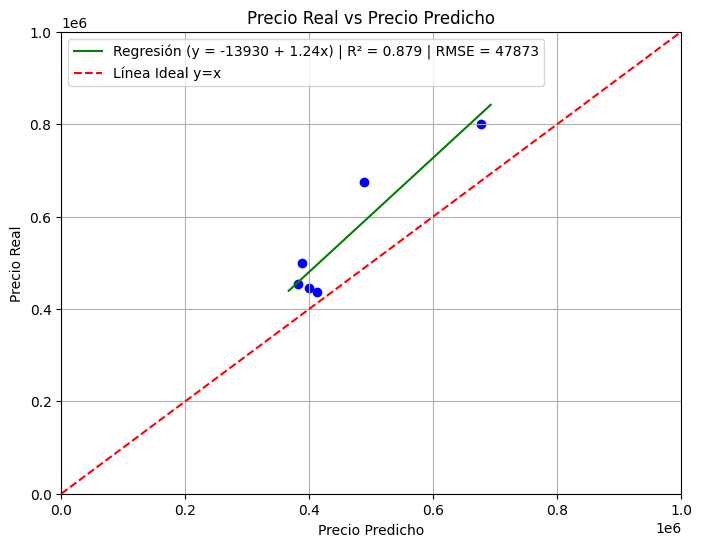

=== Predicciones con precios ajustados ===

Casa 1: Predicción ajustada = $479,777 | Precio real = $446,000
         Error porcentual ajustado = 7.57%

Casa 2: Predicción ajustada = $457,579 | Precio real = $455,000
         Error porcentual ajustado = 0.57%

Casa 3: Predicción ajustada = $466,509 | Precio real = $500,000
         Error porcentual ajustado = 6.70%

Casa 4: Predicción ajustada = $495,589 | Precio real = $436,000
         Error porcentual ajustado = 13.67%

Casa 5: Predicción ajustada = $589,089 | Precio real = $675,000
         Error porcentual ajustado = 12.73%

Casa 6: Predicción ajustada = $823,457 | Precio real = $800,000
         Error porcentual ajustado = 2.93%



In [144]:





precios_predichos = []
# Probamos las predicciones
print("=== Predicciones con la función robusta ===\n")
for i, casa in enumerate(lista, start=1):
    X_casa = pd.DataFrame([casa])
    pred_log = best_model.predict(X_casa)[0]
    pred_price = np.expm1(pred_log)
    precios_predichos.append(pred_price)
     #precio
    real_price = Precios[f"casa_{i}"]
    print(f"Casa {i}: Predicción = ${pred_price:,.0f} | Precio real = ${real_price:,.0f}")
    #error porcentual
    error_pct = abs(pred_price - real_price) / real_price * 100
    print(f"         Error porcentual = {error_pct:.2f}%\n")


y_predicho = np.array(precios_predichos).reshape(-1, 1)
y_real_array = np.array(list(Precios.values())).reshape(-1, 1)
reg = LinearRegression().fit(y_predicho, y_real_array)
alpha = reg.intercept_[0]
beta = reg.coef_[0][0]

# Graficamos: predicho en X, real en Y
plt.figure(figsize=(8,6))
plt.scatter(precios_predichos, list(Precios.values()), color='blue')

plt.xlabel('Precio Predicho')
plt.ylabel('Precio Real')
plt.title('Precio Real vs Precio Predicho')

# línea de regresión ajustada
x_vals = np.array(plt.gca().get_xlim())
y_vals = alpha + beta * x_vals
r2 = r2_score(list(Precios.values()), [alpha + beta * p for p in precios_predichos])
#rmse entre precios ajustados y su regresion
rmse = np.sqrt(mean_squared_error(list(Precios.values()), [alpha + beta * p for p in precios_predichos]))
plt.plot(x_vals, y_vals, color='green', linestyle='-', label=f'Regresión (y = {alpha:.0f} + {beta:.2f}x) | R² = {r2:.3f} | RMSE = {rmse:.0f}')

# línea ideal y = x
plt.plot([0, 1000000], [0, 1000000], color='red', linestyle='--', label='Línea Ideal y=x')

plt.xlim(0, 1000000)
plt.ylim(0, 1000000)
plt.legend()
plt.grid()
plt.show()

# -- PRECIOS AJUSTADOS --
print("=== Predicciones con precios ajustados ===\n")
for i, casa in enumerate(lista, start=1):
    X_casa = pd.DataFrame([casa])
    pred_log = best_model.predict(X_casa)[0]
    pred_price = np.expm1(pred_log)
    # Ajuste lineal
    pred_price_ajustado = alpha + beta * pred_price
    real_price = Precios[f"casa_{i}"]
    print(f"Casa {i}: Predicción ajustada = ${pred_price_ajustado:,.0f} | Precio real = ${real_price:,.0f}")
    #error porcentual
    error_pct = abs(pred_price_ajustado - real_price) / real_price * 100
    print(f"         Error porcentual ajustado = {error_pct:.2f}%\n")






